In [1]:
import numpy as np
import joblib
import os, yaml, sys
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)
from sklearn.decomposition import PCA
from dadapy import data

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from dim_redu_anns.utils import get_relevant_output_layers, get_layer_out_shape
from pref_viewing.utils import plot_imgs
from alignment.utils import get_usual_transform
from parallel.parallel_funcs import print_wise

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[Tiziano-Causin.local:89016] shmem: mmap: an error occurred while determining whether or not /var/folders/nw/yf48zdjj1m5012281wx_pzhc0000gn/T//ompi.Tiziano-Causin.501/jf.0/999948288/sm_segment.Tiziano-Causin.501.3b9a0000.0 could be created.


In [2]:
# hyperparameters
neurons_perc = 10
img_num = 7
space_option = "cca" # "random", "pca", "cca"

In [3]:
# sample indices
sampled_indices = [0, 1, 2, 100, 20000, 300, 20492] 


In [4]:
imagenet_val_path = f"{paths['data_path']}/imagenet/val"
transform = get_usual_transform()
batch_size = 1
loader = DataLoader(
    Subset(datasets.ImageFolder(imagenet_val_path, transform=transform), sampled_indices),
    batch_size=batch_size,
    num_workers=1,
    shuffle=False,
    pin_memory=True,
    timeout=500,
)

In [5]:
# network setting
test_network = "alexnet"
test_model_cls = getattr(models, test_network)
test_model = test_model_cls(pretrained=True).to(device).eval()
test_layer = "features.0"
test_feature_extractor = create_feature_extractor(test_model, return_nodes=[test_layer]).to(
    device
)
tot_neurons = np.prod(get_layer_out_shape(test_feature_extractor, test_layer))


/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
rand_neu_num = int(tot_neurons*neurons_perc/100)
random_neu_idx = np.random.choice(tot_neurons, rand_neu_num, replace=False)

In [7]:
# network pass (picking some random units)
# neurons number index
# TODO ADD percentage and save as csv file
counter = 0
all_feats = []
for inputs, _ in loader:
    counter += 1
    print_wise(f"starting batch {counter}")
    with torch.no_grad():
        inputs = inputs.to(device)
        feats = test_feature_extractor(inputs)[test_layer]
        feats = feats.view(feats.size(0), -1).cpu().numpy()
        feats = feats[:, random_neu_idx]
        all_feats.append(feats)
# end for inputs, _ in loader:
all_acts = np.concatenate(all_feats, axis=0)


/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


08:34:20 - starting batch 1
08:34:20 - starting batch 2
08:34:20 - starting batch 3
08:34:20 - starting batch 4
08:34:20 - starting batch 5
08:34:20 - starting batch 6
08:34:20 - starting batch 7


In [8]:
all_acts.shape

(7, 19360)

In [9]:
# PCA and spectrum or ID estimation
pca = PCA(n_components=min(rand_neu_num, img_num))
pca.fit(all_acts)
print(pca.explained_variance_ratio_)

[3.4429082e-01 2.0000920e-01 1.6877699e-01 1.3699646e-01 9.1126084e-02
 5.8800396e-02 7.4570517e-14]


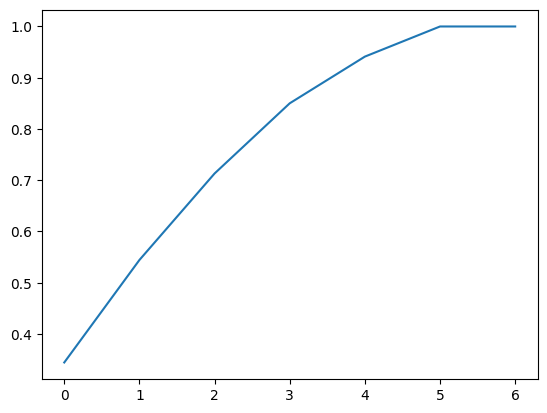

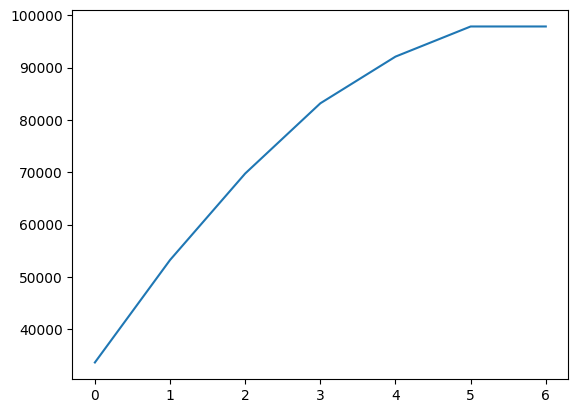

In [10]:
import matplotlib.pyplot as plt
plt.plot(range(min(rand_neu_num, img_num)), np.cumsum(pca.explained_variance_ratio_))
plt.figure()
plt.plot(range(min(rand_neu_num, img_num)), np.cumsum(pca.explained_variance_))


In [20]:
# initialise the Data class
_data = data.Data(all_acts[:6,:])
# estimate ID
id_twoNN, _, r = _data.compute_id_2NN()

print(f"ID = {id_twoNN}; r = {r}".format(id_twoNN, r))


ID = 7.838711206152329; r = 383.371912356143
